In [3]:
from MOT import MOT
import numpy as np
import matplotlib.pyplot as plt
import os
from BfTableGenerator import RansacCollector
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
from Utils import *
from DDBSCAN import Raster_DBSCAN
import open3d as op3
# op3.visualization.webrtc_server.enable_webrtc()
from open3d.web_visualizer import draw
from VisulizerTools import *
from numpy.lib.stride_tricks import sliding_window_view
from scipy.stats import multivariate_normal
import cv2
from shapely.geometry import LineString

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [4]:
def get_affinity_mat_jpd_TR(state,state_,P_,mea):
    State_affinity = np.zeros((state_.shape[1],state_.shape[0],mea.shape[0]))
    for i,s_ in enumerate(state_):
         # includes the pred states for two reprs 
         # s_: 2 x 6 x 1
        state_cur = state[i].copy().reshape(2,-1)[:,:2]
        state_pred = s_.copy().reshape(2,-1)[:,:2]
        
         # cov_tr : 2 x 6 x 6 
        cov_tr = P_[i][:,:2,:2]
        var_tr = [multivariate_normal(mean=state_pred[k], cov=cov_tr[k]) for k in range(state_cur.shape[0])]
        for j,m in enumerate(mea):
            mea_next = m.copy().reshape(2,-1)
            for k in range(s_.shape[0]):
                dis_error = np.sqrt(np.sum((state_pred[k] - mea_next[k])**2))
                if dis_error < 5:
                    jp = var_tr[k].pdf(mea_next[k])
                    State_affinity[k,i,j] = jp
    
    return np.max(State_affinity,axis = 0)

In [5]:
def get_representative_point(rows,cols,Td_map): 
    td_freq_map = Td_map
    longitudes = theta[rows]*np.pi / 180
    latitudes = azimuths[cols] * np.pi / 180 
    hypotenuses = td_freq_map[rows,cols] * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = td_freq_map[rows,cols] * np.sin(longitudes)
    
    return np.array([X,Y]).reshape(-1,2,1) # n_repr x xy_dim x 1 

In [6]:
os.getcwd()

'D:\\Lidar-Tracker'

In [7]:
# os.chdir(r'/Users/czhui960/Documents/Lidar/RawLidarData/FrameSamplingTest')
# thred_map = np.load(r'Output File/thred_map_1200.npy')
collector = RansacCollector(pcap_path=r'D:\LiDAR_Data\Veteran.pcap',output_file_path=r'D:\LiDAR_Data',update_frame_num=2000)
collector.gen_tdmap()
collector.gen_thredmap(d = 2,thred_s = 0.1,N = 10,delta_thred = 1e-3,step = 0.1)

Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.58it/s]


Generating Threshold Map


In [8]:
db = Raster_DBSCAN(window_size=(5,17),eps = 1.6, min_samples= 15,Td_map_szie=collector.thred_map.shape)   
Td_map = collector.aggregated_map[660]
Foreground_map = (Td_map < collector.thred_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= collector.thred_map)&(Td_map != 0)

In [19]:
td_freq_map[rows,cols].mean()

20.01968729641694

In [43]:
rows,cols = np.where(Labeling_map == 6)
td_freq_map = Td_map
longitudes = theta[rows]*np.pi / 180
latitudes = azimuths[cols] * np.pi / 180 
hypotenuses = td_freq_map[rows,cols] * np.cos(longitudes)
X = hypotenuses * np.sin(latitudes)
Y = hypotenuses * np.cos(latitudes)
Z = td_freq_map[rows,cols] * np.sin(longitudes)
points = np.array([X,Y]).T
points_num = len(points)
rect = cv2.minAreaRect(points.astype('float32'))
box = cv2.boxPoints(rect)
# box = cv2.boxPoints(rect)
b1 = np.sqrt(np.sum((box[1] - box[0])**2))
b2 = np.sqrt(np.sum((box[2] - box[1])**2))
length = b1
width = b2
dir_vec = box[1] - box[0]
if b1 < b2:
    length = b2
    width = b1
    dir_vec = box[2] - box[1]
dir_vec = dir_vec/np.sqrt(np.sum(dir_vec**2))
height = Z.max() - Z.min()
dis = td_freq_map[rows,cols].mean()
area = length * width

In [44]:
vec = np.array([dis,points_num,dir_vec[0],dir_vec[1],height,length,width]).reshape(-1,1)
vec = np.full((2,7,1),vec)

In [50]:
test = np.ones((2,2,1))

In [52]:
np.concatenate([test,vec],axis = 1).shape

(2, 9, 1)

In [182]:
x_begin,x_end = border_cen_0[0],border_cen_1[0]
y_begin,y_end = border_cen_0[1],border_cen_1[1]
x = np.arange(x_begin,x_end,0.5)
y = np.arange(y_begin,y_end,0.5)

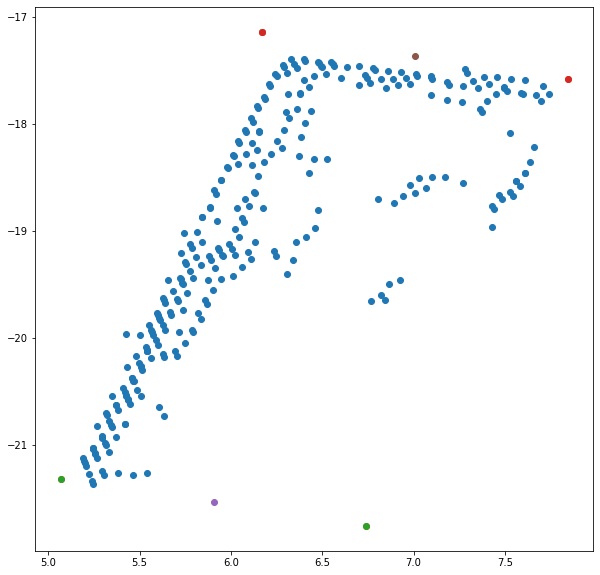

In [177]:
plt.figure(figsize=(10,10))
plt.scatter(X,Y)
plt.scatter(box[:,0],box[:,1])
plt.scatter(point_n_0[:,0],point_n_0[:,1])
plt.scatter(point_n_1[:,0],point_n_1[:,1])
plt.scatter(border_cen_0[0],border_cen_0[1])
plt.scatter(border_cen_1[0],border_cen_1[1])

# plt.ylim(-9,-3)
# plt.xlim(7,13)

In [91]:
points = np.array([X,Y]).T

In [97]:
rect = cv2.minAreaRect(points.astype('float32'))
box = cv2.boxPoints(rect)

In [99]:
box 

array([[  3.315392 , -14.334942 ],
       [  4.8521543, -14.8026085],
       [  6.1363635, -10.582678 ],
       [  4.5996013, -10.115011 ]], dtype=float32)

In [ ]:
cv2.minAreaRect()

In [72]:
Z.max() - Z.min()

1.785243188025055

In [66]:
pcd = get_pcd_colored_filtered(Td_map,Labeling_map,Foreground_map)

In [67]:
draw(pcd)

WebVisualizer(window_uid='window_19')

In [38]:
draw(pcd)

WebVisualizer(window_uid='window_9')

In [84]:
db = Raster_DBSCAN(window_size=(5,13),eps = 1.7, min_samples= 17,Td_map_szie=collector.thred_map.shape)   
for frame in range(700):
    Td_map = collector.aggregated_map[frame]
    Foreground_map = (Td_map < collector.thred_map)&(Td_map != 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    Background_map = (Td_map >= collector.thred_map)&(Td_map != 0)
    thred_merge = 80
    unique_label = np.unique(Labeling_map)
    #Only Background contains 
    if -1 in unique_label:
        unique_label = unique_label[1:]
    occlusion_indicator = -np.ones((len(azimuths))).astype('int')
    rowses = []
    colses = []
    for l in unique_label:
        rows,cols = np.where(Labeling_map == l)
        occlusion_indicator[cols] = l
        rowses.append(rows)
        colses.append(cols)
    TSAv = occlusion_indicator != -1
    counts,appears = count(TSAv)
    Merge_cobs = []
    ind_pairs = [(i,i+1) for i in range(len(counts) - 1)]
    ind_pairs += [(-1,0)]
    for pair in ind_pairs:
        col_right = appears[pair[0]] + counts[pair[0]] - 1
        col_left = appears[pair[1]]
        is_normal = col_left >= col_right
        if is_normal&((col_left - col_right) > thred_merge):
            continue
        bounder_right_label = occlusion_indicator[col_right]
        bounder_left_label = occlusion_indicator[col_left]
        # right-bound on left ---- left-boundon right
        label_ind_right= np.where(unique_label == bounder_right_label)[0][0]
        rows_right = rowses[label_ind_right][colses[label_ind_right] == col_right]
        label_ind_left = np.where(unique_label == bounder_left_label)[0][0]
        rows_left = rowses[label_ind_left][colses[label_ind_left] == col_left]
        rows_2bounds = np.concatenate([rows_left,rows_right])
        high,low = rows_2bounds.max(),rows_2bounds.min()
        if is_normal:
            interval_map = Td_map[low:high+1,col_right:col_left+1][Background_map[low:high+1,col_right:col_left+1]]
        else:
            if (len(azimuths) - col_right) + col_left > thred_merge:
                continue
            else: 
                interval_map_right = Td_map[low:high+1,col_right:len(azimuths)][Background_map[low:high+1,col_right:len(azimuths)]]
                interval_map_left = Td_map[low:high+1,:col_left + 1][Background_map[low:high+1,:col_left + 1]]
                interval_map = np.concatenate([interval_map_left,interval_map_right])
        if len(interval_map) == 0 :
            continue

        min_dis_int = interval_map.min()
        min_dis_right = Td_map[rows_right,col_right].min()
        min_dis_left = Td_map[rows_left,col_left].min()
        if (min_dis_int  < min_dis_right)&(min_dis_int < min_dis_left)&(np.abs(min_dis_right - min_dis_left) < 1.2):
            Merge_cobs.append([label_ind_right,label_ind_left])

    for cob in Merge_cobs:
        for i in range(1,len(cob)):
            Labeling_map[Labeling_map == cob[i]] = cob[0]
            unique_label[unique_label == cob[i]] = cob[0]

    new_uni_labels = np.unique(unique_label)
    xy_set = []
    for label in new_uni_labels:
        rows,cols = np.where(Labeling_map == label)
        sort_ind = np.argsort(cols)
        refer_cols = cols[sort_ind[[0,-1]]]
        # this is being said, the first place is for less azimuth id 
        refer_rows = rows[sort_ind[[0,-1]]]
        if np.abs(refer_cols[0] - refer_cols[1]) >= 900:
            cols[cols <= 900] += 1800
            sort_ind = np.argsort(cols)
            refer_cols = cols[sort_ind[[0,-1]]]
            refer_cols[refer_cols >= 1800] -= 1800
            refer_rows = rows[sort_ind[[0,-1]]]
        xy_set.append(get_representative_point(refer_rows,refer_cols,Td_map))

In [11]:
db = Raster_DBSCAN(window_size=(5,13),eps = 1.7, min_samples= 17,Td_map_szie=collector.thred_map.shape)   


In [24]:
Td_map = collector.aggregated_map[1000]
Foreground_map = (Td_map < collector.thred_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= collector.thred_map)&(Td_map != 0)


thred_merge = 30
unique_label = np.unique(Labeling_map)
#Only Background contains 
if -1 in unique_label:
    unique_label = unique_label[1:]
occlusion_indicator = -np.ones((len(azimuths))).astype('int')
rowses = []
colses = []
for l in unique_label:
    rows,cols = np.where(Labeling_map == l)
    occlusion_indicator[cols] = l
    rowses.append(rows)
    colses.append(cols)
TSAv = occlusion_indicator != -1
counts,appears = count(TSAv)
Merge_cobs = []
ind_pairs = [(i,i+1) for i in range(len(counts) - 1)]
ind_pairs += [(-1,0)]
for pair in ind_pairs:
    col_right = appears[pair[0]] + counts[pair[0]] - 1
    col_left = appears[pair[1]]
    is_normal = col_left >= col_right
    if is_normal&((col_left - col_right) > thred_merge):
        continue
    bounder_right_label = occlusion_indicator[col_right]
    bounder_left_label = occlusion_indicator[col_left]
    # right-bound on left ---- left-bound on right
    label_ind_right= np.where(unique_label == bounder_right_label)[0][0]
    rows_right = rowses[label_ind_right][colses[label_ind_right] == col_right]
    label_ind_left = np.where(unique_label == bounder_left_label)[0][0]
    rows_left = rowses[label_ind_left][colses[label_ind_left] == col_left]
    rows_2bounds = np.concatenate([rows_left,rows_right])
    high,low = rows_2bounds.max(),rows_2bounds.min()
    if is_normal:
        interval_map = Td_map[low:high+1,col_right:col_left+1][Background_map[low:high+1,col_right:col_left+1]]
    else:
        if (len(azimuths) - col_right) + col_left > thred_merge:
            continue
        else: 
            interval_map_right = Td_map[low:high+1,col_right:len(azimuths)][Background_map[low:high+1,col_right:len(azimuths)]]
            interval_map_left = Td_map[low:high+1,:col_left + 1][Background_map[low:high+1,:col_left + 1]]
            interval_map = np.concatenate([interval_map_left,interval_map_right])
    if len(interval_map) == 0 :
        continue

    min_dis_int = interval_map.min()
    min_dis_right = Td_map[rows_right,col_right].min()
    min_dis_left = Td_map[rows_left,col_left].min()
    if (min_dis_int  < min_dis_right)&(min_dis_int < min_dis_left)&(np.abs(min_dis_right - min_dis_left) < 2.5):
        Merge_cobs.append([label_ind_right,label_ind_left])

for cob in Merge_cobs:
    for i in range(1,len(cob)):
        Labeling_map[Labeling_map == cob[i]] = cob[0]
        unique_label[unique_label == cob[i]] = cob[0]

new_uni_labels = np.unique(unique_label)
xy_set = []
for label in new_uni_labels:
    rows,cols = np.where(Labeling_map == label)
    sort_ind = np.argsort(cols)
    refer_cols = cols[sort_ind[[0,-1]]]
    # this is being said, the first place is for less azimuth id 
    refer_rows = rows[sort_ind[[0,-1]]]
    if np.abs(refer_cols[0] - refer_cols[1]) >= 900:
        cols[cols <= 900] += 1800
        sort_ind = np.argsort(cols)
        refer_cols = cols[sort_ind[[0,-1]]]
        refer_cols[refer_cols >= 1800] -= 1800
        refer_rows = rows[sort_ind[[0,-1]]]
    xy_set.append(get_representative_point(refer_rows,refer_cols,Td_map))




pcd = get_pcd_colored(Td_map,Labeling_map,Foreground_map)
draw(pcd, height = 1000,width = 1000)

WebVisualizer(window_uid='window_9')

In [25]:
from scipy.spatial import distance

In [28]:
from numpy.linalg import inv

In [69]:
V = np.array([
    [1,0.2],
    [0.3,2]
])
VI = inv(V)
distance.mahalanobis([1.1,0], [0,0], VI)

1.116880781646981

In [37]:
distance.mahalanobis?